In [157]:
import json
from boto3.dynamodb.types import TypeDeserializer

def ddb_deserialize(r, type_deserializer = TypeDeserializer()):
  return type_deserializer.deserialize({"M": r})

In [570]:
import boto3
import pandas

cols = ['quaternionTimestamp','linearAccerationTimestamp', 'quaternionW',	'quaternionX',	'quaternionY','quaternionZ', 'linearAccerationX', 'linearAccerationZ', 'linearAccerationY'	]

def ddb_query(query):
  client = boto3.client('dynamodb')
  items = []
  resp = client.execute_statement(Statement=query, Limit=1000)
  items.extend(resp['Items'])
  while 'LastEvaluatedKey' in resp:
    resp = client.execute_statement(Statement=query,Limit=1000,NextToken=resp["NextToken"])
    items.extend(resp['Items'])

  items = [ ddb_deserialize(r) for r in items ]

  return items

def query_sessions_and_sections(query, sectionTable="SessionSection-e3tq3jp6jjh4xjjpvydbqj64e4-dev"):
  
  sessions = ddb_query(query)
  sessions_df = pandas.DataFrame(sessions)

  sections_query= f"""SELECT * FROM "{sectionTable}" WHERE sessionID in {list(sessions_df['id'])} """
  sections = ddb_query(sections_query)
  sections_df = pandas.DataFrame(sections)
  
  return sessions_df, sections_df

def join_sessions_and_sections(sessions_df, sections_df):

  sections_df  = (sections_df.groupby(['sessionID'])
        .agg({'start': lambda x: x.tolist(),'end': lambda x: x.tolist()})
        .reset_index())
  sessions_df = sessions_df.set_index('id').join(sections_df.set_index('sessionID'), rsuffix='-section')
  sessions_df['isInSection'] = None
  sessions_df.sort_values('_lastChangedAt')
  return sessions_df

def normalize_rows(sessions_df):
  def normalize_sample_length(row):
    m = 9e100
    for c in cols:
      m = min(m,len(row[c]))
    for c in cols:
      row[c] = row[c][len(row[c])-m:]
  
  sessions_df.apply(normalize_sample_length, axis=1)
  return sessions_df
  

def explode_sessions(sessions_df):
  sessions_df = sessions_df.explode(cols)
  names = {}
  def gen_isInSection(row):
    if row['name'] not in names:
      names[row['name']] = None
    row['isInSection'] = 0
    for i in range(len(row['start'])):
      if row['linearAccerationTimestamp'] > row['start'][i] and row['linearAccerationTimestamp'] < row['end'][i]:
        row['isInSection'] = (len(names)-1)*3 + i + 1
      
  sessions_df.apply(gen_isInSection, axis=1)
  return sessions_df


,__typename,_lastChangedAt,linearAccerationTimestamp,createdAt,name,quaternionW,quaternionX,linearAccerationZ,quaternionY,linearAccerationY,quaternionZ,_version,linearAccerationX,updatedAt,owner,quaternionTimestamp,start,end,isInSection
id,,,,,,,,,,,,,,,,,,,
b86cb531-6295-46b8-ab6f-4e602c773a03,Session,1672523000392,1672522899.1020002,2022-12-31T21:43:20.346Z,3fakerotate3,0.7682638764381409,0.052508361637592316,-0.03406253084540367,-0.6338822841644287,0.005085946060717106,-0.07215818762779236,1,-0.006927246227860451,2022-12-31T21:43:20.346Z,7a9b678d-ba89-41ff-b463-c59c2f7a1278::jamie_pr...,1672522899.1020002,"[1672522966.845, 1672522974.013, 1672522970.274]","[1672522968.962, 1672522976.352, 1672522972.614]",0
b86cb531-6295-46b8-ab6f-4e602c773a03,Session,1672523000392,1672522899.1100001,2022-12-31T21:43:20.346Z,3fakerotate3,0.7680739164352417,0.05263308063149452,-0.027786383405327797,-0.6341435313224792,0.00924747996032238,-0.07179184257984161,1,0.08566512167453766,2022-12-31T21:43:20.346Z,7a9b678d-ba89-41ff-b463-c59c2f7a1278::jamie_pr...,1672522899.1100001,"[1672522966.845, 1672522974.013, 1672522970.274]","[1672522968.962, 1672522976.352, 1672522972.614]",0
b86cb531-6295-46b8-ab6f-4e602c773a03,Session,1672523000392,1672522899.1210003,2022-12-31T21:43:20.346Z,3fakerotate3,0.7681723237037659,0.05202347785234451,-0.010495861060917377,-0.6341198682785034,-0.014705520123243332,-0.0713912770152092,1,0.026853788644075394,2022-12-31T21:43:20.346Z,7a9b678d-ba89-41ff-b463-c59c2f7a1278::jamie_pr...,1672522899.1210003,"[1672522966.845, 1672522974.013, 1672522970.274]","[1672522968.962, 1672522976.352, 1672522972.614]",0
b86cb531-6295-46b8-ab6f-4e602c773a03,Session,1672523000392,1672522899.131,2022-12-31T21:43:20.346Z,3fakerotate3,0.768403947353363,0.051224496215581894,-0.06488268077373505,-0.6339308023452759,-0.018546367064118385,-0.07115507870912552,1,-0.023580722510814667,2022-12-31T21:43:20.346Z,7a9b678d-ba89-41ff-b463-c59c2f7a1278::jamie_pr...,1672522899.131,"[1672522966.845, 1672522974.013, 1672522970.274]","[1672522968.962, 1672522976.352, 1672522972.614]",0
b86cb531-6295-46b8-ab6f-4e602c773a03,Session,1672523000392,1672522899.1410003,2022-12-31T21:43:20.346Z,3fakerotate3,0.7687993049621582,0.05041876807808876,-0.057226426899433136,-0.6335350871086121,-0.0029151826165616512,-0.07098434120416641,1,-0.00358591228723526,2022-12-31T21:43:20.346Z,7a9b678d-ba89-41ff-b463-c59c2f7a1278::jamie_pr...,1672522899.1410003,"[1672522966.845, 1672522974.013, 1672522970.274]","[1672522968.962, 1672522976.352, 1672522972.614]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c0927c1d-ed5c-4f83-996f-cda6a13512dc,Session,1672523199591,1672523172.2430003,2022-12-31T21:46:39.535Z,3fakerotate5,0.7663623690605164,0.006937158294022083,-0.012425449676811695,-0.6386776566505432,0.006083914078772068,0.06878674030303955,1,-0.0011448973091319203,2022-12-31T21:46:39.535Z,7a9b678d-ba89-41ff-b463-c59c2f7a1278::jamie_pr...,1672523172.2430003,"[1672523161.469, 1672523169.1, 1672523165.275]","[1672523164.024, 1672523171.712, 1672523167.753]",0
c0927c1d-ed5c-4f83-996f-cda6a13512dc,Session,1672523199591,1672523172.2540002,2022-12-31T21:46:39.535Z,3fakerotate5,0.7663373351097107,0.006865763571113348,-0.018232379108667374,-0.638698935508728,0.00386780290864408,0.06887488812208176,1,-0.008461134508252144,2022-12-31T21:46:39.535Z,7a9b678d-ba89-41ff-b463-c59c2f7a1278::jamie_pr...,1672523172.2540002,"[1672523161.469, 1672523169.1, 1672523165.275]","[1672523164.024, 1672523171.712, 1672523167.753]",0
c0927c1d-ed5c-4f83-996f-cda6a13512dc,Session,1672523199591,1672523172.2640002,2022-12-31T21:46:39.535Z,3fakerotate5,0.7663150429725647,0.006797791924327612,-0.010862982831895351,-0.6387173533439636,0.005546833388507366,0.06895876675844193,1,-0.005034611560404301,2022-12-31T21:46:39.535Z,7a9b678d-ba89-41ff-b463-c59c2f7a1278::jamie_pr...,1672523172.2640002,"[1672523161.469, 1672523169.1, 1672523165.275]","[1672523164.024, 1672523171.712, 1672523167

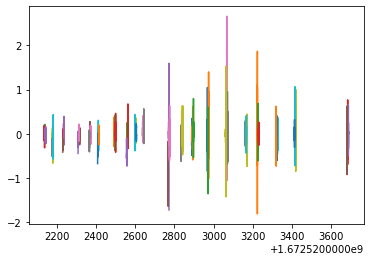

In [573]:
import matplotlib.pyplot as plt
query= """SELECT * FROM "Session-e3tq3jp6jjh4xjjpvydbqj64e4-dev" WHERE CONTAINS("name", 'fake')"""

sessions_df, sections_df = query_sessions_and_sections(query)
sessions_df = join_sessions_and_sections(sessions_df, sections_df)
sessions_df = normalize_rows(sessions_df)
sessions_df = explode_sessions(sessions_df)

for i in range(sessions_df['isInSection'].max()):
  move = sessions_df.loc[sessions_df['isInSection'] == i+1]
  plt.plot(move['linearAccerationTimestamp'], move['linearAccerationZ'])

sessions_df.groupby('name')

In [577]:
import numpy as np

def resample_fixed(df, n_new):
  n_old, m = df.to_numpy().shape
  mat_old = df.to_numpy().astype(float)
  mat_new = np.zeros((n_new, m))
  x_old = np.linspace(df.index.astype(float).min(), df.index.astype(float).max(), n_old)
  x_new = np.linspace(df.index.astype(float).min(), df.index.astype(float).max(), n_new)

  for j in range(m):
    y_old = mat_old[:, j]
    y_new = np.interp(x_new, x_old, y_old)
    mat_new[:, j] = y_new

  return pandas.DataFrame(mat_new[:,1:], index=x_new, columns=df.columns[1:])

moves=[]
names=[]
for i in range(sessions_df['isInSection'].max()):
  move = sessions_df.loc[sessions_df['isInSection'] == i+1]
  name = move['name'].iloc[0]
  names.append('rotate' if 'rotate' in name else 'squat')
  move = resample_fixed(move[cols[1:]].set_index('linearAccerationTimestamp'), 500)
  moves.append(move)
  

['rotate',
 'rotate',
 'rotate',
 'rotate',
 'rotate',
 'rotate',
 'rotate',
 'rotate',
 'rotate',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'rotate',
 'rotate',
 'rotate',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'rotate',
 'rotate',
 'rotate',
 'squat',
 'squat',
 'squat',
 'rotate',
 'rotate',
 'rotate',
 'rotate',
 'rotate',
 'rotate',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'squat',
 'rotate',
 'rotate',
 'rotate',
 'squat',
 'squat',
 'squat',
 'rotate',
 'rotate',
 'rotate',
 'rotate',
 'rotate',
 'rotate']

In [584]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(500, 6)),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(2)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
for m in moves:
  print(m.to_numpy())
model.fit([m.to_numpy() for  m in moves], names, epochs=10)
# Call model on a test input
# x = moves[0]
# y = model(x)
# y

[[ 0.06187161 -0.58026677  0.00770069  0.02930793 -0.16267467  0.00464433]
 [ 0.0619427  -0.58127963  0.0077268   0.02830383 -0.16320566  0.00445824]
 [ 0.06201378 -0.58229248  0.00775291  0.02729973 -0.16373665  0.00427215]
 ...
 [-0.1695005  -0.52119012  0.09676541  0.01765583  0.16874562  0.20246101]
 [-0.16665212 -0.52117515  0.0976574   0.02605336  0.13403319  0.16603552]
 [-0.16380373 -0.52116019  0.09854939  0.03445088  0.09932075  0.12961003]]
[[ 0.03103526 -0.64929891 -0.02350028  0.02538019  0.05750674 -0.04690051]
 [ 0.03083581 -0.64926293 -0.02346905  0.02125045  0.0647161  -0.04174921]
 [ 0.03063636 -0.64922696 -0.02343783  0.01712092  0.07192509 -0.03659817]
 ...
 [ 0.0231725  -0.64235795 -0.05607721 -0.0060482   0.03961828  0.0141342 ]
 [ 0.02245089 -0.64190815 -0.05596038 -0.01169398  0.02672116  0.01175593]
 [ 0.02172924 -0.64145833 -0.05584354 -0.01734005  0.01382337  0.00937755]]
[[ 0.00853189 -0.64387614 -0.04872282 -0.0400222   0.00166195  0.00772447]
 [ 0.00802938

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {"<class 'str'>"})